<a href="https://colab.research.google.com/github/kevin6449/ironman2024_genai/blob/main/gen_ai_day19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使用 t-SNE 以視覺化方式呈現嵌入

In [17]:
import google.generativeai as genai

from google.colab import userdata

API_KEY=userdata.get('GOOGLE_API_KEY')

#genai.configure(api_key="YOUR_API_KEY")

# Configure the client library by providing your API key.
genai.configure(api_key=API_KEY)

### 設定環境

In [18]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 可以用的model

In [19]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


### 資料集

20 Newsgroups Text Dataset 包含 20 個主題的 18,000 個新聞群組貼文，分為訓練和測試集。

In [20]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 訓練集中的範例

In [21]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [22]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [23]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)
# Retain text samples that can be used in the gecko model.
df_train = df_train[df_train['Text'].str.len() < 10000]

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


訓練資料集中收集 100 個資料點，並捨棄幾個類別以執行本教學課程，以對部分資料進行取樣。選擇要比較的科學類別。

In [24]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,Re: Clipper considered harmful\nLines: 12\n\n...,11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,"Re: Would ""clipper"" make a good cover for oth...",11,sci.crypt
3,1653,Re: Fifth Amendment and Passwords\nNntp-Posti...,11,sci.crypt
4,1654,Re: 80-bit keyseach machine\nOrganization: Ad...,11,sci.crypt
...,...,...,...,...
595,2245,Re: HST Servicing Mission\nLines: 19\nOrganiza...,14,sci.space
596,2246,Organization: Queen's University at Kingston\n...,14,sci.space
597,2247,Level 5?\nX-Added: Forwarded by Space Digest\...,14,sci.space
598,2248,Re: Eco-Freaks forcing Space Mining.\nOrganiz...,14,sci.space


In [25]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## 建立嵌入

將 API 變更為使用模型嵌入功能 001 的嵌入
新的嵌入模型「embedding-001」其中有新的工作類型參數和選用標題 (僅適用於 task_type=RETRIEVAL_DOCUMENT)。

這些新參數僅適用於最新的嵌入模型。工作類型如下：
工作類型
 - RETRIEVAL_QUERY : 指定指定文字是搜尋/擷取設定中的查詢。
 - RETRIEVAL_DOCUMENT : 指定文字是搜尋/擷取設定中的文件。
 - SEMANTIC_SIMILARITY : 指定指定文字將用於語意文字相似度 (STS)。
 - 分類 : 指定要將嵌入用於分類。
 - 叢集 : 指定嵌入將用於分群。

### 降低維度

文件嵌入向量的長度為 768 個字元。為了視覺化呈現內嵌文件的分組方式，您必須套用維度縮減功能，因為您只能在 2D 或 3D 空間中視覺化嵌入嵌入。

In [30]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]

  return embed_fn

def create_embeddings(df):
  model = 'models/text-embedding-004'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)



  0%|          | 0/600 [00:00<?, ?it/s]

In [31]:
len(df_train['Embeddings'][0])

768

In [32]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

應用 t-DistributedStochastic Neighbor Embedding (t-SNE) 方法來縮減維度。這項技巧可以減少維度數量，同時保留叢集 (相近距離的資料點)。針對原始資料，模型會嘗試建構分佈，並與其他資料點「相鄰」(舉例來說，兩者的意義相近)。接著會最佳化目標函式，在圖表中保持類似的分佈。




In [33]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [34]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-26.201687,3.669643,sci.crypt
1,-22.183727,-2.414644,sci.crypt
2,-25.294945,9.438068,sci.crypt
3,-31.704041,-0.041459,sci.crypt
4,-13.089652,-3.241879,sci.crypt
...,...,...,...
595,18.489141,2.900763,sci.space
596,24.345039,-7.461753,sci.space
597,24.200418,0.517541,sci.space
598,29.019669,-1.276329,sci.space


(-37.68777713775635, 37.86644611358643, -41.47599582672119, 44.98421649932861)

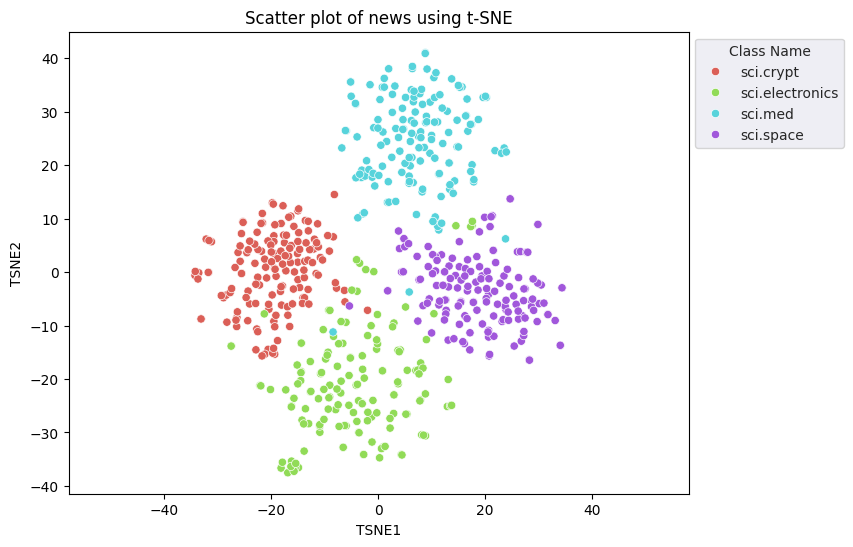

In [35]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## 比較 KMeans 的結果

KMeans 分群法是一種熱門的分群演算法，通常用於非監督式學習。疊代決定最佳的 k 中心點，並將每個範例指派給最接近的質心。直接將嵌入項目輸入 KMeans 演算法，比較嵌入的視覺化效果與機器學習演算法的成效。

In [36]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [37]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Class Name,Cluster
0,-26.201687,3.669643,sci.crypt,1
1,-22.183727,-2.414644,sci.crypt,2
2,-25.294945,9.438068,sci.crypt,1
3,-31.704041,-0.041459,sci.crypt,1
4,-13.089652,-3.241879,sci.crypt,1
...,...,...,...,...
595,18.489141,2.900763,sci.space,2
596,24.345039,-7.461753,sci.space,2
597,24.200418,0.517541,sci.space,2
598,29.019669,-1.276329,sci.space,2


(-37.68777713775635, 37.86644611358643, -41.47599582672119, 44.98421649932861)

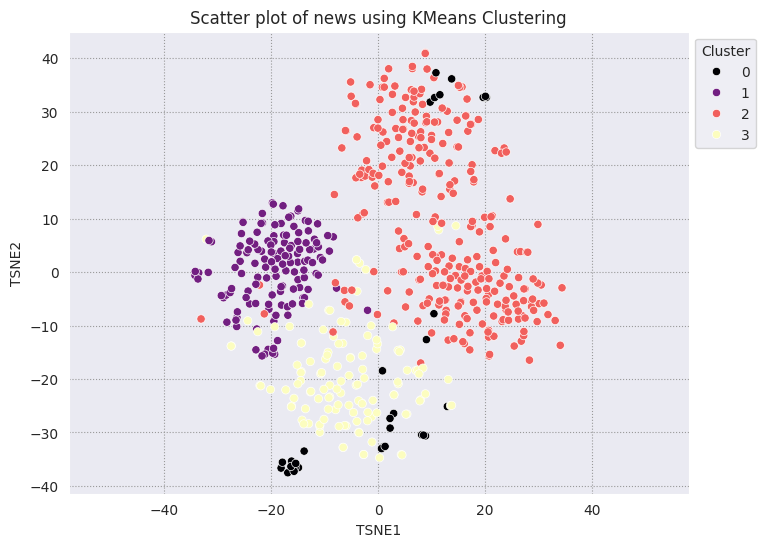

In [38]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [45]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    cluster = rows.Cluster.mode().values[0]
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [43]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

{'sci.crypt': 1, 'sci.electronics': 3, 'sci.med': 2, 'sci.space': 2}

取得每個群組內的大多數叢集，並查看該群組中實際有多少成員。

In [49]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}
# df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)
df_tsne['Predicted'] = df_tsne['Cluster'].map(lambda x: class_by_id.get(x, 'Unknown'))


# Filter to the correctly matched rows
correct = df_tsne[df_tsne['Class Name'] == df_tsne['Predicted']]

# Summarise, as a percentage
acc = correct['Class Name'].value_counts() / SAMPLE_SIZE
acc

,count
Class Name,
sci.space,1.000000
sci.crypt,0.920000
sci.electronics,0.773333


In [51]:
# Get predicted values by name
df_tsne['Predicted'] = ''
for idx, rows in df_tsne.iterrows():
  cluster = rows['Cluster']
  # Get key from mapping based on cluster value
  # key = list(class_clusters.keys())[list(class_clusters.values()).index(cluster)]
  # df_tsne.at[idx, 'Predicted'] = key
  if cluster in class_clusters.values():
    # Get key from mapping based on cluster value
    key = list(class_clusters.keys())[list(class_clusters.values()).index(cluster)]
    df_tsne.at[idx, 'Predicted'] = key
  else:
    # Handle the case where the cluster value is not found
    df_tsne.at[idx, 'Predicted'] = 'Unknown'

df_tsne

,TSNE1,TSNE2,Class Name,Cluster,Predicted
0,-26.201687,3.669643,sci.crypt,1,sci.crypt
1,-22.183727,-2.414644,sci.crypt,2,sci.med
2,-25.294945,9.438068,sci.crypt,1,sci.crypt
3,-31.704041,-0.041459,sci.crypt,1,sci.crypt
4,-13.089652,-3.241879,sci.crypt,1,sci.crypt
...,...,...,...,...,...
595,18.489141,2.900763,sci.space,2,sci.med
596,24.345039,-7.461753,sci.space,2,sci.med
597,24.200418,0.517541,sci.space,2,sci.med
598,29.019669,-1.276329,sci.space,2,sci.med


### 以視覺化方式呈現資料所套用 KMeans 的成效，可以使用混淆矩陣。混淆矩陣可讓您評估分類模型在準確率以外的表現。

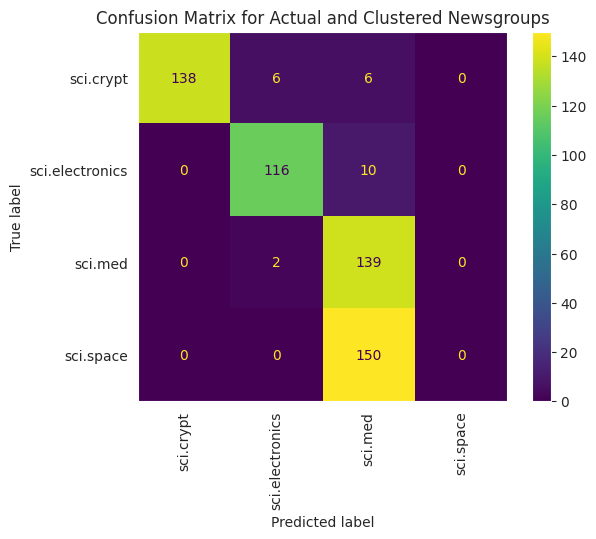

In [53]:
# cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list())
cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list(), labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)